# H5T0_CNN: implement a 2D CNN using PyTorch for image classification

### create your "signature":
#### Run the cell but do NOT modify the cell
#### The signature needs to be displayed right below the cell in this file

In [1]:
import platform, socket, getpass
from time import time
from datetime import datetime
import random
signature_for_cnn=[socket.gethostbyname(socket.gethostname()),
                   getpass.getuser(),
                   datetime.now(),
                   random.random()]
print(signature_for_cnn) 

['10.5.0.2', 'ARamo', datetime.datetime(2025, 12, 10, 23, 57, 44, 340006), 0.9065790899169204]


In [2]:
#sample code to save model and signature
#torch.save({"model":model.state_dict(),
#            "signature":signature_for_cnn},
#            "CNN_best.pt") 

### This is a complete application of image classification using a 2D CNN
steps: \
define a 2D CNN \
define a function for training the CNN \
define a function for testing the CNN \
define a function for saving the model and your `signature_for_cnn` \
load data \
train the CNN in a for loop using the training set and the validation set\
evalaute the best model on the test set\
display accuracy and confusion matrix for each of the three sets: train, validation, and test sets
### you may use the code in lecture nodes
### write your code below this line

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
data = torch.load("H5T0_train_val_test_data.pt", weights_only=False)
X_train = data["X_train"]
Y_train = data["Y_train"]
X_val = data["X_val"]
Y_val = data["Y_val"]
X_test = data["X_test"]
Y_test = data["Y_test"]

print(f"Data shapes before reshape: X_train={X_train.shape}, Y_train={Y_train.shape}")

X_train = torch.from_numpy(X_train).float().unsqueeze(1)
Y_train = torch.from_numpy(Y_train).long()
X_val = torch.from_numpy(X_val).float().unsqueeze(1)
Y_val = torch.from_numpy(Y_val).long()
X_test = torch.from_numpy(X_test).float().unsqueeze(1)
Y_test = torch.from_numpy(Y_test).long()

print(f"Data shapes after reshape: X_train={X_train.shape}, Y_train={Y_train.shape}")

Data shapes before reshape: X_train=(1000, 28, 28), Y_train=(1000,)
Data shapes after reshape: X_train=torch.Size([1000, 1, 28, 28]), Y_train=torch.Size([1000])


In [5]:
class CNN2D(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc2(self.dropout(self.relu3(self.fc1(x))))
        return x

In [6]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(Y_batch.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, np.array(all_preds), np.array(all_labels)

In [7]:
model = CNN2D(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epochs = 50
best_val_accuracy = 0.0
best_model_state = None
train_losses = []
val_accuracies = []

print("Starting CNN training...")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    val_accuracy, _, _ = evaluate(model, val_loader, device)
    val_accuracies.append(val_accuracy)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict().copy()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.4f} - Best model saved!")
    else:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
print(f"\nBest validation accuracy: {best_val_accuracy:.4f}")

Starting CNN training...
Epoch 1/50, Loss: 1.8685, Val Accuracy: 0.6000 - Best model saved!
Epoch 2/50, Loss: 1.1232, Val Accuracy: 0.6960 - Best model saved!
Epoch 3/50, Loss: 0.9027, Val Accuracy: 0.7360 - Best model saved!
Epoch 4/50, Loss: 0.7488, Val Accuracy: 0.7530 - Best model saved!
Epoch 5/50, Loss: 0.7108, Val Accuracy: 0.7620 - Best model saved!
Epoch 6/50, Loss: 0.6169, Val Accuracy: 0.7730 - Best model saved!
Epoch 7/50, Loss: 0.5889, Val Accuracy: 0.7810 - Best model saved!
Epoch 8/50, Loss: 0.5497, Val Accuracy: 0.7970 - Best model saved!
Epoch 9/50, Loss: 0.5299, Val Accuracy: 0.7990 - Best model saved!
Epoch 10/50, Loss: 0.5007, Val Accuracy: 0.7970
Epoch 11/50, Loss: 0.4439, Val Accuracy: 0.7960
Epoch 12/50, Loss: 0.4366, Val Accuracy: 0.8090 - Best model saved!
Epoch 13/50, Loss: 0.4196, Val Accuracy: 0.8110 - Best model saved!
Epoch 14/50, Loss: 0.3960, Val Accuracy: 0.8130 - Best model saved!
Epoch 15/50, Loss: 0.3812, Val Accuracy: 0.8250 - Best model saved!
Epoc


Final Results:
Training Accuracy: 0.9920
Validation Accuracy: 0.8480
Test Accuracy: 0.8280


C:\Users\ARamo\AppData\Local\Temp\ipykernel_30332\1852246357.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


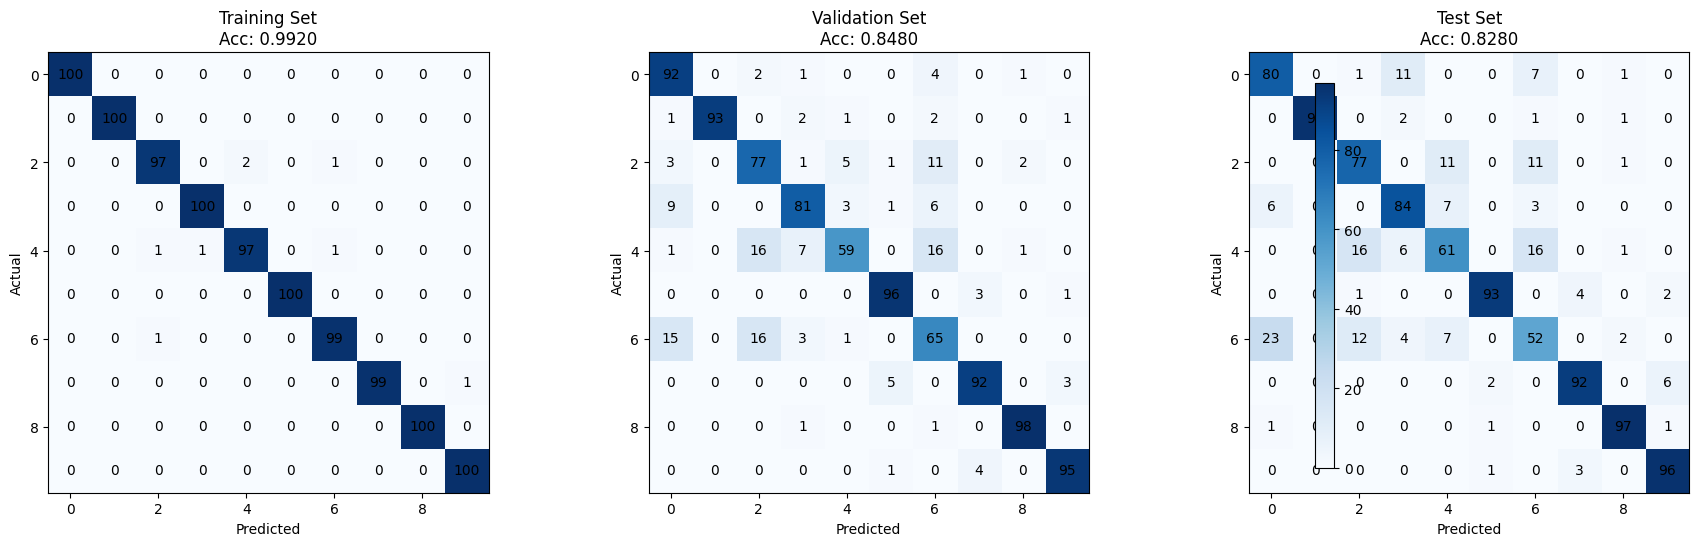

In [8]:
train_accuracy, train_preds, train_labels = evaluate(model, train_loader, device)
val_accuracy, val_preds, val_labels = evaluate(model, val_loader, device)
test_accuracy, test_preds, test_labels = evaluate(model, test_loader, device)

print(f"\nFinal Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion matrices
train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)
test_cm = confusion_matrix(test_labels, test_preds)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
panels = [
    (axes[0], train_cm, 'Training Set', train_accuracy),
    (axes[1], val_cm, 'Validation Set', val_accuracy),
    (axes[2], test_cm, 'Test Set', test_accuracy),
]
for ax, cm, title, acc in panels:
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(f"{title}\nAcc: {acc:.4f}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    # Annotate each cell with integer counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center', color='black')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.tight_layout()
plt.show()

In [9]:
torch.save({"model": best_model_state,
            "signature": signature_for_cnn},
           "CNN_best.pt")
print("Best model saved to CNN_best.pt")

Best model saved to CNN_best.pt
